In [1]:
import sys,os,re
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sb

from theory_code.distance_theory import TheoryCalcs
from mock_data.mock_data_code    import MockCalcs

from cobaya.run import run

from itertools import product
from copy      import deepcopy
from time      import time
from bios      import read

from scipy.interpolate import interp1d
from scipy.integrate   import trapz

import warnings
warnings.filterwarnings('ignore')

import matplotlib
from matplotlib import rc
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm

rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})


sidelegend = {'bbox_to_anchor': (1.04,0.5), 
              'loc': "center left",
              'frameon': False}

/home/Matteo/anaconda3/envs/cloe/lib/python3.9/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


# Settings

## Theory

In [2]:
fiducial = {'H0': 68.53,
            'omegam': 0.2948,
            'ombh2': 0.02218,
            'omk': 0.,
            'epsilon0_EM': 0.0,
            'a_EM': 1.,
            'n_EM': 1.,
            'epsilon0_GW': 0.05,
            'a_GW': 1.,
            'n_GW': 1.,
            'mnu': 0.06,
            'nnu': 3.,
            'MB': -19.2435,
            'rd': 147.0}

settings = {'zmin': 0.001,
            'zmax': 5.,
            'Nz': 1000,
            'zdrag': 1060,
            'DDR_model': {'epsilon_model': 'polynomial',
                          'pade': False},
            'BBN': True}

darksirens_path = '/home/Matteo/Projects/GW_projects/darksirens_reboot'

## Observables

In [15]:
obs_settings = {#'BAO' : {'distribution': 'binned',
                #         'error_type' : 0.05,
                #         'correlation': False,
                #         'BAO_file_path' : './mock_data/BAOmock_standard',
                #         'zmin': 0.65,
                #         'zmax': 1.85,
                #         'N_bin': 14,
                #         'run_settings': {'varpar': 'H0',
                #                          'varvec': np.linspace(62,74,100),
                #                          'noisy': False}
                #        },
                #'SN' : {'distribution': 'Euclid',
                #        'error_type' : 'LSST-like',
                #        'correlation': False,
                #        'SN_file_path' : './mock_data/SNmock_standard',
                #        'zmin': 0.1,
                #        'zmax': 1.0,
                #        'N_SN': 8800,
                #        #'run_settings': {'file': 'settings/SN_LCDM.yaml',
                #        #                 'varpar': 'omegam',
                #        #                 'varvec': np.linspace(0.1,0.5,10)}
                #       },
                #'GW_old' : {'distribution': 'BNS',
                #            'error_type' : 0.1,
                #            'GW_file_path' : './mock_data/GWmock_standard',
                #            'correlation': False,
                #            'zmin': 0.001,
                #            'zmax': 5.0,
                #            'N_gw': 1000,
                #            'run_settings': {'varpar': 'epsilon0_GW',
                #                             'varvec': np.linspace(-0.1,0.1,100),
                #                             'noisy': False}
                #      },
                'GW' : {'distribution': 'BNS',
                        'error_type' : 'GWfish',
                        'survey': ['ET'], #Needed for GWfish
                        'GW_file_path' : './mock_data/GWmock_realistic',
                        'correlation': False,
                        'zmin': 0.001,
                        'zmax': 5.0,
                        'N_gw': 1000,
                        'run_settings': {'varpar': 'epsilon0_GW',
                                         'varvec': np.linspace(-0.05,0.2,100),
                                         'noisy': True}
                      },
               }

# Creating mock data

## Getting fiducial theory

In [4]:
fiducial_theory = TheoryCalcs(settings,fiducial)
zplot = np.linspace(0.01,3,100)

epsilon_GW =  0.05


## Initializing mock class

In [5]:
mock = MockCalcs(settings, obs_settings, fiducial, fiducial_theory)

CREATING MOCKS FOR ['GW']



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:45<00:00,  4.43it/s]

CREATED GW DATASET


## BAO data

**Minor problem here: the format with which BAO_data is obtained is different from the one used in the likelihood. we should make those match**

**Also, DV should probably be on different redshifts than DH and DM**

In [6]:
if 'BAO' in obs_settings:
    BAO_data = mock.data_BAO

In [7]:
if 'BAO' in obs_settings:
    
    zplot = np.linspace(min(BAO_data['z']),max(BAO_data['z']),100)
    
    fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True,subplot_kw=dict(frameon=True),figsize=(10,5))
    axes[0].errorbar(BAO_data['z'],BAO_data['DH_noisy'],yerr=BAO_data['err_DH'],ls='',marker='*',color='black')
    axes[0].plot(zplot,fiducial_theory.DH(zplot))
    axes[0].set_xlabel(r'$z$')
    axes[0].set_ylabel(r'$D_H(z)$')
    
    axes[1].errorbar(BAO_data['z'],BAO_data['DM_noisy'],yerr=BAO_data['err_DM'],ls='',marker='*',color='black')
    axes[1].plot(zplot,fiducial_theory.DM(zplot))
    axes[1].set_xlabel(r'$z$')
    axes[1].set_ylabel(r'$D_M(z)$')
    
    axes[2].errorbar(BAO_data['z'],BAO_data['DV_noisy'],yerr=BAO_data['err_DV'],ls='',marker='*',color='black')
    axes[2].plot(zplot,fiducial_theory.DV(zplot))
    axes[2].set_xlabel(r'$z$')
    axes[2].set_ylabel(r'$D_V(z)$')
    
    plt.tight_layout();

## SN data

In [8]:
if 'SN' in obs_settings:
    SN_data = deepcopy(mock.data_SN)
    weird = []
    for z,val,err in zip(SN_data['z'],SN_data['mB'],SN_data['err_mB']):
        if val<fiducial_theory.mB(z)+2*err and val>fiducial_theory.mB(z)-2*err:
            weird.append('No')
        else:
            weird.append('Yes')
    SN_data['Weird'] = weird
    
    SNdf = pd.DataFrame.from_dict(SN_data)

In [9]:
if 'SN' in obs_settings:
    print('Weird points are {}%'.format(100*(len(SNdf[SNdf['Weird']=='Yes']))/len(SNdf)))
    zplot = np.linspace(min(SN_data['z']),max(SN_data['z']),100)
    
    plt.figure()
    plt.errorbar(SN_data['z'],SN_data['mB_noisy'],yerr=SN_data['err_mB'],ls='',marker='',color='black')
    sb.scatterplot(SNdf,x='z',y='mB_noisy',hue='Weird')
    plt.plot(zplot,fiducial_theory.mB(zplot))
    plt.xlabel(r'$z$')
    plt.ylabel(r'$m_B(z)$');

## Standard Sirens data

In [10]:
if 'GW' in obs_settings:    
    GW_data = deepcopy(mock.data_GW)
    weird = []
    for z,val,err in zip(GW_data['z'],GW_data['dL'],GW_data['err_dL']):
        if val<fiducial_theory.DL_GW(z)+2*err and val>fiducial_theory.DL_GW(z)-2*err:
            weird.append('No')
        else:
            weird.append('Yes')
    GW_data['Weird'] = weird
    GWdf = pd.DataFrame.from_dict(GW_data)

Weird points are 0.0%


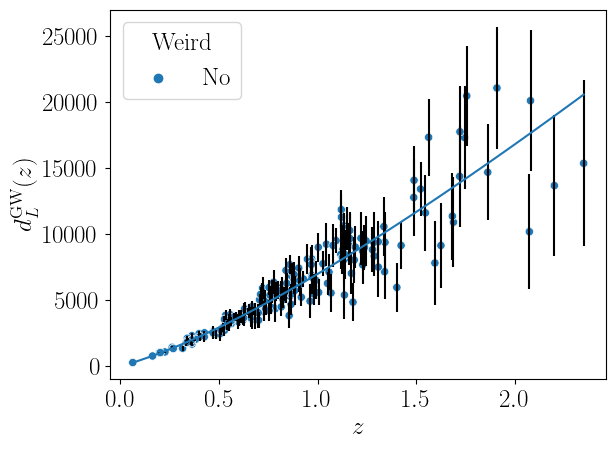

In [11]:
if 'GW' in obs_settings: 
    print('Weird points are {}%'.format(100*len(GWdf[GWdf['Weird']=='Yes'])/len(GWdf)))
    zplot = np.linspace(min(GW_data['z']),max(GW_data['z']),100)
    
    plt.figure()
    plt.errorbar(GWdf['z'],GWdf['dL_noisy'],yerr=GWdf['err_dL'],ls='',marker='',color='black')
    sb.scatterplot(GWdf,x='z',y='dL_noisy',hue='Weird')
    plt.plot(zplot,fiducial_theory.DL_GW(zplot))
    plt.xlabel(r'$z$')
    plt.ylabel(r'$d_L^{\rm GW}(z)$');

# Grid testing in created data

In [16]:
from likelihood.BAO_likelihood         import BAOLike
from likelihood.SN_likelihood          import SNLike
from likelihood.GW_likelihood          import GWLike
from theory_code.cobaya_theory_wrapper import CalcDist

dflist = []

for obs,obs_dict in obs_settings.items():
    if 'run_settings' in obs_dict:
        rundict = obs_dict['run_settings']
        info = read('settings/BAO+GW_LCDM.yaml')
        
        info['likelihood'] = {}
        if obs == 'BAO':
            info['likelihood']['BAOLike'] = {'external': BAOLike,
                                             'BAO_data_path': obs_dict['BAO_file_path'],
                                             'use_noisy_data': obs_dict['run_settings']['noisy']}
        
        if obs == 'SN':
            info['likelihood']['SNLike'] =  {'external': SNLike,
                                             'SN_data_path': obs_dict['SN_file_path'],
                                             'use_noisy_data': obs_dict['run_settings']['noisy']}
        
        if obs == 'GW':
            info['likelihood']['GWLike'] =  {'external': GWLike,
                                             'GW_data_path': obs_dict['GW_file_path'],
                                             'use_noisy_data': obs_dict['run_settings']['noisy']}
        
        info['theory'] = {'CalcDist': {'external': CalcDist,
                                       'DDR_model': info['DDR_model']}}

        del info['output']
        for par,par_dict in info['params'].items():
            if par != rundict['varpar']:
                if type(par_dict) == dict and 'prior' in par_dict:
                    info['params'][par] = fiducial[par]
                    
        for val in rundict['varvec']:
            temp = deepcopy(info)
            temp['sampler'] = {'evaluate': {'override': {rundict['varpar']: val}}}
            updated_info,sampler = run(temp)
            
            dflist.append(pd.DataFrame.from_dict({'parameter': [val],
                                                  'loglike': [sampler.logposterior.loglike],
                                                  'Observable': [obs]}))
            
test_results = pd.concat(dflist,ignore_index=True)

INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.05


[evaluate] Reference point:
   epsilon0_GW = -0.05


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -119.588


epsilon_GW =  -0.05
[evaluate] log-posterior  = -119.588


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -119.588


[evaluate] log-likelihood = -119.588


INFO:evaluate:   chi2_GWLike = 239.175


[evaluate]    chi2_GWLike = 239.175


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.0474747


[evaluate] Reference point:
   epsilon0_GW = -0.0474747


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -118.665


epsilon_GW =  -0.047474747474747475
[evaluate] log-posterior  = -118.665


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -118.665


[evaluate] log-likelihood = -118.665


INFO:evaluate:   chi2_GWLike = 237.329


[evaluate]    chi2_GWLike = 237.329


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.0449495


[evaluate] Reference point:
   epsilon0_GW = -0.0449495


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -117.763


epsilon_GW =  -0.044949494949494954
[evaluate] log-posterior  = -117.763


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -117.763


[evaluate] log-likelihood = -117.763


INFO:evaluate:   chi2_GWLike = 235.525


[evaluate]    chi2_GWLike = 235.525


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.0424242


[evaluate] Reference point:
   epsilon0_GW = -0.0424242


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -116.882


 -0.04242424242424243
[evaluate] log-posterior  = -116.882


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -116.882


[evaluate] log-likelihood = -116.882


INFO:evaluate:   chi2_GWLike = 233.763


[evaluate]    chi2_GWLike = 233.763


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.039899


[evaluate] Reference point:
   epsilon0_GW = -0.039899


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -116.022


epsilon_GW =  -0.0398989898989899
[evaluate] log-posterior  = -116.022


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -116.022


[evaluate] log-likelihood = -116.022


INFO:evaluate:   chi2_GWLike = 232.043


[evaluate]    chi2_GWLike = 232.043


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.0373737


[evaluate] Reference point:
   epsilon0_GW = -0.0373737


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -115.183


epsilon_GW =  -0.03737373737373738
[evaluate] log-posterior  = -115.183


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -115.183


[evaluate] log-likelihood = -115.183


INFO:evaluate:   chi2_GWLike = 230.366


[evaluate]    chi2_GWLike = 230.366


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.0348485


[evaluate] Reference point:
   epsilon0_GW = -0.0348485


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  -0.03484848484848485


INFO:evaluate:log-posterior  = -114.365


[evaluate] log-posterior  = -114.365


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -114.365


[evaluate] log-likelihood = -114.365


INFO:evaluate:   chi2_GWLike = 228.731


[evaluate]    chi2_GWLike = 228.731


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.0323232


[evaluate] Reference point:
   epsilon0_GW = -0.0323232


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -113.569


epsilon_GW =  -0.03232323232323232
[evaluate] log-posterior  = -113.569


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -113.569


[evaluate] log-likelihood = -113.569


INFO:evaluate:   chi2_GWLike = 227.139


[evaluate]    chi2_GWLike = 227.139


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.029798


[evaluate] Reference point:
   epsilon0_GW = -0.029798


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -112.795


 -0.0297979797979798
[evaluate] log-posterior  = -112.795


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -112.795


[evaluate] log-likelihood = -112.795


INFO:evaluate:   chi2_GWLike = 225.59


[evaluate]    chi2_GWLike = 225.59


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.0272727


[evaluate] Reference point:
   epsilon0_GW = -0.0272727


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  -0.027272727272727275


INFO:evaluate:log-posterior  = -112.042


[evaluate] log-posterior  = -112.042


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -112.042


[evaluate] log-likelihood = -112.042


INFO:evaluate:   chi2_GWLike = 224.084


[evaluate]    chi2_GWLike = 224.084


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.0247475


[evaluate] Reference point:
   epsilon0_GW = -0.0247475


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -111.311


 -0.024747474747474747
[evaluate] log-posterior  = -111.311


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -111.311


[evaluate] log-likelihood = -111.311


INFO:evaluate:   chi2_GWLike = 222.621


[evaluate]    chi2_GWLike = 222.621


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.0222222


[evaluate] Reference point:
   epsilon0_GW = -0.0222222


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -110.601


epsilon_GW =  -0.022222222222222223
[evaluate] log-posterior  = -110.601


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -110.601


[evaluate] log-likelihood = -110.601


INFO:evaluate:   chi2_GWLike = 221.202


[evaluate]    chi2_GWLike = 221.202


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.019697


[evaluate] Reference point:
   epsilon0_GW = -0.019697


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -109.914


 -0.0196969696969697
[evaluate] log-posterior  = -109.914


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -109.914


[evaluate] log-likelihood = -109.914


INFO:evaluate:   chi2_GWLike = 219.827


[evaluate]    chi2_GWLike = 219.827


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.0171717


[evaluate] Reference point:
   epsilon0_GW = -0.0171717


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -109.248


 -0.01717171717171717
[evaluate] log-posterior  = -109.248


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -109.248


[evaluate] log-likelihood = -109.248


INFO:evaluate:   chi2_GWLike = 218.496


[evaluate]    chi2_GWLike = 218.496


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.0146465


[evaluate] Reference point:
   epsilon0_GW = -0.0146465


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -108.604


 -0.014646464646464644
[evaluate] log-posterior  = -108.604


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -108.604


[evaluate] log-likelihood = -108.604


INFO:evaluate:   chi2_GWLike = 217.209


[evaluate]    chi2_GWLike = 217.209


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.0121212


[evaluate] Reference point:
   epsilon0_GW = -0.0121212


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -107.983


 -0.012121212121212123
[evaluate] log-posterior  = -107.983


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -107.983


[evaluate] log-likelihood = -107.983


INFO:evaluate:   chi2_GWLike = 215.966


[evaluate]    chi2_GWLike = 215.966


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.00959596


[evaluate] Reference point:
   epsilon0_GW = -0.00959596


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -107.384


epsilon_GW =  -0.009595959595959595
[evaluate] log-posterior  = -107.384


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -107.384


[evaluate] log-likelihood = -107.384


INFO:evaluate:   chi2_GWLike = 214.768


[evaluate]    chi2_GWLike = 214.768


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.00707071


[evaluate] Reference point:
   epsilon0_GW = -0.00707071


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -106.807


epsilon_GW =  -0.007070707070707068
[evaluate] log-posterior  = -106.807


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -106.807


[evaluate] log-likelihood = -106.807


INFO:evaluate:   chi2_GWLike = 213.615


[evaluate]    chi2_GWLike = 213.615


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.00454545


[evaluate] Reference point:
   epsilon0_GW = -0.00454545


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -106.253


epsilon_GW =  -0.004545454545454547
[evaluate] log-posterior  = -106.253


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -106.253


[evaluate] log-likelihood = -106.253


INFO:evaluate:   chi2_GWLike = 212.506


[evaluate]    chi2_GWLike = 212.506


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = -0.0020202


[evaluate] Reference point:
   epsilon0_GW = -0.0020202


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -105.721


epsilon_GW =  -0.0020202020202020193
[evaluate] log-posterior  = -105.721


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -105.721


[evaluate] log-likelihood = -105.721


INFO:evaluate:   chi2_GWLike = 211.443


[evaluate]    chi2_GWLike = 211.443


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.000505051


[evaluate] Reference point:
   epsilon0_GW = 0.000505051


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.0005050505050505083


INFO:evaluate:log-posterior  = -105.212


[evaluate] log-posterior  = -105.212


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -105.212


[evaluate] log-likelihood = -105.212


INFO:evaluate:   chi2_GWLike = 210.425


[evaluate]    chi2_GWLike = 210.425


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0030303


[evaluate] Reference point:
   epsilon0_GW = 0.0030303


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -104.726


epsilon_GW =  0.003030303030303029
[evaluate] log-posterior  = -104.726


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -104.726


[evaluate] log-likelihood = -104.726


INFO:evaluate:   chi2_GWLike = 209.452


[evaluate]    chi2_GWLike = 209.452


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.00555556


[evaluate] Reference point:
   epsilon0_GW = 0.00555556


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -104.263


epsilon_GW =  0.005555555555555557
[evaluate] log-posterior  = -104.263


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -104.263


[evaluate] log-likelihood = -104.263


INFO:evaluate:   chi2_GWLike = 208.525


[evaluate]    chi2_GWLike = 208.525


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.00808081


[evaluate] Reference point:
   epsilon0_GW = 0.00808081


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -103.822


epsilon_GW =  0.008080808080808084
[evaluate] log-posterior  = -103.822


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -103.822


[evaluate] log-likelihood = -103.822


INFO:evaluate:   chi2_GWLike = 207.645


[evaluate]    chi2_GWLike = 207.645


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0106061


[evaluate] Reference point:
   epsilon0_GW = 0.0106061


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -103.405


epsilon_GW =  0.010606060606060605
[evaluate] log-posterior  = -103.405


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -103.405


[evaluate] log-likelihood = -103.405


INFO:evaluate:   chi2_GWLike = 206.81


[evaluate]    chi2_GWLike = 206.81


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0131313


[evaluate] Reference point:
   epsilon0_GW = 0.0131313


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -103.011


 0.013131313131313133
[evaluate] log-posterior  = -103.011


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -103.011


[evaluate] log-likelihood = -103.011


INFO:evaluate:   chi2_GWLike = 206.022


[evaluate]    chi2_GWLike = 206.022


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0156566


[evaluate] Reference point:
   epsilon0_GW = 0.0156566


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.01565656565656566


INFO:evaluate:log-posterior  = -102.64


[evaluate] log-posterior  = -102.64


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -102.64


[evaluate] log-likelihood = -102.64


INFO:evaluate:   chi2_GWLike = 205.28


[evaluate]    chi2_GWLike = 205.28


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0181818


[evaluate] Reference point:
   epsilon0_GW = 0.0181818


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -102.292


epsilon_GW =  0.018181818181818188
[evaluate] log-posterior  = -102.292


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -102.292


[evaluate] log-likelihood = -102.292


INFO:evaluate:   chi2_GWLike = 204.585


[evaluate]    chi2_GWLike = 204.585


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0207071


[evaluate] Reference point:
   epsilon0_GW = 0.0207071


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -101.968


epsilon_GW =  0.020707070707070716
[evaluate] log-posterior  = -101.968


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -101.968


[evaluate] log-likelihood = -101.968


INFO:evaluate:   chi2_GWLike = 203.937


[evaluate]    chi2_GWLike = 203.937


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0232323


[evaluate] Reference point:
   epsilon0_GW = 0.0232323


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -101.668


epsilon_GW =  0.02323232323232323
[evaluate] log-posterior  = -101.668


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -101.668


[evaluate] log-likelihood = -101.668


INFO:evaluate:   chi2_GWLike = 203.336


[evaluate]    chi2_GWLike = 203.336


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0257576


[evaluate] Reference point:
   epsilon0_GW = 0.0257576


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -101.391


 0.025757575757575757
[evaluate] log-posterior  = -101.391


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -101.391


[evaluate] log-likelihood = -101.391


INFO:evaluate:   chi2_GWLike = 202.783


[evaluate]    chi2_GWLike = 202.783


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0282828


[evaluate] Reference point:
   epsilon0_GW = 0.0282828


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.028282828282828285


INFO:evaluate:log-posterior  = -101.138


[evaluate] log-posterior  = -101.138


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -101.138


[evaluate] log-likelihood = -101.138


INFO:evaluate:   chi2_GWLike = 202.277


[evaluate]    chi2_GWLike = 202.277


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0308081


[evaluate] Reference point:
   epsilon0_GW = 0.0308081


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.030808080808080812


INFO:evaluate:log-posterior  = -100.909


[evaluate] log-posterior  = -100.909


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.909


[evaluate] log-likelihood = -100.909


INFO:evaluate:   chi2_GWLike = 201.819


[evaluate]    chi2_GWLike = 201.819


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0333333


[evaluate] Reference point:
   epsilon0_GW = 0.0333333


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.03333333333333334


INFO:evaluate:log-posterior  = -100.704


[evaluate] log-posterior  = -100.704


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.704


[evaluate] log-likelihood = -100.704


INFO:evaluate:   chi2_GWLike = 201.409


[evaluate]    chi2_GWLike = 201.409


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0358586


[evaluate] Reference point:
   epsilon0_GW = 0.0358586


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -100.524


epsilon_GW =  0.03585858585858587
[evaluate] log-posterior  = -100.524


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.524


[evaluate] log-likelihood = -100.524


INFO:evaluate:   chi2_GWLike = 201.047


[evaluate]    chi2_GWLike = 201.047


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0383838


[evaluate] Reference point:
   epsilon0_GW = 0.0383838


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -100.367


epsilon_GW =  0.038383838383838395
[evaluate] log-posterior  = -100.367


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.367


[evaluate] log-likelihood = -100.367


INFO:evaluate:   chi2_GWLike = 200.734


[evaluate]    chi2_GWLike = 200.734


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0409091


[evaluate] Reference point:
   epsilon0_GW = 0.0409091


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.04090909090909091


INFO:evaluate:log-posterior  = -100.235


[evaluate] log-posterior  = -100.235


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.235


[evaluate] log-likelihood = -100.235


INFO:evaluate:   chi2_GWLike = 200.469


[evaluate]    chi2_GWLike = 200.469


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0434343


[evaluate] Reference point:
   epsilon0_GW = 0.0434343


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -100.127


 0.043434343434343436
[evaluate] log-posterior  = -100.127


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.127


[evaluate] log-likelihood = -100.127


INFO:evaluate:   chi2_GWLike = 200.253


[evaluate]    chi2_GWLike = 200.253


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0459596


[evaluate] Reference point:
   epsilon0_GW = 0.0459596


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -100.043


epsilon_GW =  0.045959595959595964
[evaluate] log-posterior  = -100.043


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.043


[evaluate] log-likelihood = -100.043


INFO:evaluate:   chi2_GWLike = 200.087


[evaluate]    chi2_GWLike = 200.087


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0484848


[evaluate] Reference point:
   epsilon0_GW = 0.0484848


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -99.9846


epsilon_GW =  0.04848484848484849
[evaluate] log-posterior  = -99.9846


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -99.9846


[evaluate] log-likelihood = -99.9846


INFO:evaluate:   chi2_GWLike = 199.969


[evaluate]    chi2_GWLike = 199.969


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0510101


[evaluate] Reference point:
   epsilon0_GW = 0.0510101


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -99.9507


epsilon_GW =  0.05101010101010102
[evaluate] log-posterior  = -99.9507


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -99.9507


[evaluate] log-likelihood = -99.9507


INFO:evaluate:   chi2_GWLike = 199.901


[evaluate]    chi2_GWLike = 199.901


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0535354


[evaluate] Reference point:
   epsilon0_GW = 0.0535354


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -99.9416


 0.05353535353535355
[evaluate] log-posterior  = -99.9416


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -99.9416


[evaluate] log-likelihood = -99.9416


INFO:evaluate:   chi2_GWLike = 199.883


[evaluate]    chi2_GWLike = 199.883


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0560606


[evaluate] Reference point:
   epsilon0_GW = 0.0560606


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -99.9575


epsilon_GW =  0.05606060606060606
[evaluate] log-posterior  = -99.9575


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -99.9575


[evaluate] log-likelihood = -99.9575


INFO:evaluate:   chi2_GWLike = 199.915


[evaluate]    chi2_GWLike = 199.915


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0585859


[evaluate] Reference point:
   epsilon0_GW = 0.0585859


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.05858585858585859


INFO:evaluate:log-posterior  = -99.9985


[evaluate] log-posterior  = -99.9985


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -99.9985


[evaluate] log-likelihood = -99.9985


INFO:evaluate:   chi2_GWLike = 199.997


[evaluate]    chi2_GWLike = 199.997


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0611111


[evaluate] Reference point:
   epsilon0_GW = 0.0611111


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -100.065


 0.061111111111111116
[evaluate] log-posterior  = -100.065


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.065


[evaluate] log-likelihood = -100.065


INFO:evaluate:   chi2_GWLike = 200.129


[evaluate]    chi2_GWLike = 200.129


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0636364


[evaluate] Reference point:
   epsilon0_GW = 0.0636364


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -100.156


 0.06363636363636364
[evaluate] log-posterior  = -100.156


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.156


[evaluate] log-likelihood = -100.156


INFO:evaluate:   chi2_GWLike = 200.312


[evaluate]    chi2_GWLike = 200.312


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0661616


[evaluate] Reference point:
   epsilon0_GW = 0.0661616


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.06616161616161617


INFO:evaluate:log-posterior  = -100.273


[evaluate] log-posterior  = -100.273


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.273


[evaluate] log-likelihood = -100.273


INFO:evaluate:   chi2_GWLike = 200.546


[evaluate]    chi2_GWLike = 200.546


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0686869


[evaluate] Reference point:
   epsilon0_GW = 0.0686869


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -100.416


epsilon_GW =  0.0686868686868687
[evaluate] log-posterior  = -100.416


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.416


[evaluate] log-likelihood = -100.416


INFO:evaluate:   chi2_GWLike = 200.831


[evaluate]    chi2_GWLike = 200.831


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0712121


[evaluate] Reference point:
   epsilon0_GW = 0.0712121


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -100.584


 0.07121212121212121
[evaluate] log-posterior  = -100.584


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.584


[evaluate] log-likelihood = -100.584


INFO:evaluate:   chi2_GWLike = 201.167


[evaluate]    chi2_GWLike = 201.167


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0737374


[evaluate] Reference point:
   epsilon0_GW = 0.0737374


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -100.777


epsilon_GW =  0.07373737373737374
[evaluate] log-posterior  = -100.777


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.777


[evaluate] log-likelihood = -100.777


INFO:evaluate:   chi2_GWLike = 201.555


[evaluate]    chi2_GWLike = 201.555


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0762626


[evaluate] Reference point:
   epsilon0_GW = 0.0762626


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -100.997


epsilon_GW =  0.07626262626262627
[evaluate] log-posterior  = -100.997


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -100.997


[evaluate] log-likelihood = -100.997


INFO:evaluate:   chi2_GWLike = 201.994


[evaluate]    chi2_GWLike = 201.994


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0787879


[evaluate] Reference point:
   epsilon0_GW = 0.0787879


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -101.243


 0.07878787878787881
[evaluate] log-posterior  = -101.243


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -101.243


[evaluate] log-likelihood = -101.243


INFO:evaluate:   chi2_GWLike = 202.486


[evaluate]    chi2_GWLike = 202.486


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0813131


[evaluate] Reference point:
   epsilon0_GW = 0.0813131


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.08131313131313132


INFO:evaluate:log-posterior  = -101.515


[evaluate] log-posterior  = -101.515


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -101.515


[evaluate] log-likelihood = -101.515


INFO:evaluate:   chi2_GWLike = 203.029


[evaluate]    chi2_GWLike = 203.029


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0838384


[evaluate] Reference point:
   epsilon0_GW = 0.0838384


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -101.813


epsilon_GW =  0.08383838383838384
[evaluate] log-posterior  = -101.813


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -101.813


[evaluate] log-likelihood = -101.813


INFO:evaluate:   chi2_GWLike = 203.625


[evaluate]    chi2_GWLike = 203.625


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0863636


[evaluate] Reference point:
   epsilon0_GW = 0.0863636


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -102.137


 0.08636363636363638
[evaluate] log-posterior  = -102.137


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -102.137


[evaluate] log-likelihood = -102.137


INFO:evaluate:   chi2_GWLike = 204.274


[evaluate]    chi2_GWLike = 204.274


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0888889


[evaluate] Reference point:
   epsilon0_GW = 0.0888889


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  

INFO:evaluate:log-posterior  = -102.488


0.08888888888888889
[evaluate] log-posterior  = -102.488


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -102.488


[evaluate] log-likelihood = -102.488


INFO:evaluate:   chi2_GWLike = 204.975


[evaluate]    chi2_GWLike = 204.975


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0914141


[evaluate] Reference point:
   epsilon0_GW = 0.0914141


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.09141414141414143


INFO:evaluate:log-posterior  = -102.865


[evaluate] log-posterior  = -102.865


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -102.865


[evaluate] log-likelihood = -102.865


INFO:evaluate:   chi2_GWLike = 205.73


[evaluate]    chi2_GWLike = 205.73


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0939394


[evaluate] Reference point:
   epsilon0_GW = 0.0939394


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -103.269


 0.09393939393939395
[evaluate] log-posterior  = -103.269


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -103.269


[evaluate] log-likelihood = -103.269


INFO:evaluate:   chi2_GWLike = 206.538


[evaluate]    chi2_GWLike = 206.538


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0964646


[evaluate] Reference point:
   epsilon0_GW = 0.0964646


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -103.7


 0.09646464646464646
[evaluate] log-posterior  = -103.7


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -103.7


[evaluate] log-likelihood = -103.7


INFO:evaluate:   chi2_GWLike = 207.399


[evaluate]    chi2_GWLike = 207.399


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.0989899


[evaluate] Reference point:
   epsilon0_GW = 0.0989899


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -104.157


epsilon_GW =  0.098989898989899
[evaluate] log-posterior  = -104.157


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -104.157


[evaluate] log-likelihood = -104.157


INFO:evaluate:   chi2_GWLike = 208.315


[evaluate]    chi2_GWLike = 208.315


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.101515


[evaluate] Reference point:
   epsilon0_GW = 0.101515


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -104.642


 0.10151515151515152
[evaluate] log-posterior  = -104.642


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -104.642


[evaluate] log-likelihood = -104.642


INFO:evaluate:   chi2_GWLike = 209.284


[evaluate]    chi2_GWLike = 209.284


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.10404


[evaluate] Reference point:
   epsilon0_GW = 0.10404


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -105.154


epsilon_GW =  0.10404040404040406
[evaluate] log-posterior  = -105.154


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -105.154


[evaluate] log-likelihood = -105.154


INFO:evaluate:   chi2_GWLike = 210.308


[evaluate]    chi2_GWLike = 210.308


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.106566


[evaluate] Reference point:
   epsilon0_GW = 0.106566


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -105.693


epsilon_GW =  0.10656565656565657
[evaluate] log-posterior  = -105.693


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -105.693


[evaluate] log-likelihood = -105.693


INFO:evaluate:   chi2_GWLike = 211.386


[evaluate]    chi2_GWLike = 211.386


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.109091


[evaluate] Reference point:
   epsilon0_GW = 0.109091


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -106.259


epsilon_GW =  0.10909090909090911
[evaluate] log-posterior  = -106.259


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -106.259


[evaluate] log-likelihood = -106.259


INFO:evaluate:   chi2_GWLike = 212.519


[evaluate]    chi2_GWLike = 212.519


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.111616


[evaluate] Reference point:
   epsilon0_GW = 0.111616


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -106.853


epsilon_GW =  0.11161616161616163
[evaluate] log-posterior  = -106.853


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -106.853


[evaluate] log-likelihood = -106.853


INFO:evaluate:   chi2_GWLike = 213.707


[evaluate]    chi2_GWLike = 213.707


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.114141


[evaluate] Reference point:
   epsilon0_GW = 0.114141


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -107.475


epsilon_GW =  0.11414141414141414
[evaluate] log-posterior  = -107.475


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -107.475


[evaluate] log-likelihood = -107.475


INFO:evaluate:   chi2_GWLike = 214.95


[evaluate]    chi2_GWLike = 214.95


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.116667


[evaluate] Reference point:
   epsilon0_GW = 0.116667


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -108.124


 0.11666666666666668
[evaluate] log-posterior  = -108.124


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -108.124


[evaluate] log-likelihood = -108.124


INFO:evaluate:   chi2_GWLike = 216.248


[evaluate]    chi2_GWLike = 216.248


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.119192


[evaluate] Reference point:
   epsilon0_GW = 0.119192


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.1191919191919192


INFO:evaluate:log-posterior  = -108.801


[evaluate] log-posterior  = -108.801


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -108.801


[evaluate] log-likelihood = -108.801


INFO:evaluate:   chi2_GWLike = 217.603


[evaluate]    chi2_GWLike = 217.603


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.121717


[evaluate] Reference point:
   epsilon0_GW = 0.121717


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -109.506


 0.12171717171717174
[evaluate] log-posterior  = -109.506


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -109.506


[evaluate] log-likelihood = -109.506


INFO:evaluate:   chi2_GWLike = 219.013


[evaluate]    chi2_GWLike = 219.013


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.124242


[evaluate] Reference point:
   epsilon0_GW = 0.124242


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.12424242424242425


INFO:evaluate:log-posterior  = -110.24


[evaluate] log-posterior  = -110.24


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -110.24


[evaluate] log-likelihood = -110.24


INFO:evaluate:   chi2_GWLike = 220.479


[evaluate]    chi2_GWLike = 220.479


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.126768


[evaluate] Reference point:
   epsilon0_GW = 0.126768


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.1267676767676768


INFO:evaluate:log-posterior  = -111.001


[evaluate] log-posterior  = -111.001


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -111.001


[evaluate] log-likelihood = -111.001


INFO:evaluate:   chi2_GWLike = 222.002


[evaluate]    chi2_GWLike = 222.002


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.129293


[evaluate] Reference point:
   epsilon0_GW = 0.129293


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.1292929292929293


INFO:evaluate:log-posterior  = -111.791


[evaluate] log-posterior  = -111.791


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -111.791


[evaluate] log-likelihood = -111.791


INFO:evaluate:   chi2_GWLike = 223.581


[evaluate]    chi2_GWLike = 223.581


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.131818


[evaluate] Reference point:
   epsilon0_GW = 0.131818


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -112.609


 0.13181818181818183
[evaluate] log-posterior  = -112.609


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -112.609


[evaluate] log-likelihood = -112.609


INFO:evaluate:   chi2_GWLike = 225.218


[evaluate]    chi2_GWLike = 225.218


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.134343


[evaluate] Reference point:
   epsilon0_GW = 0.134343


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -113.456


epsilon_GW =  0.13434343434343438
[evaluate] log-posterior  = -113.456


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -113.456


[evaluate] log-likelihood = -113.456


INFO:evaluate:   chi2_GWLike = 226.911


[evaluate]    chi2_GWLike = 226.911


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.136869


[evaluate] Reference point:
   epsilon0_GW = 0.136869


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.13686868686868686


INFO:evaluate:log-posterior  = -114.331


[evaluate] log-posterior  = -114.331


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -114.331


[evaluate] log-likelihood = -114.331


INFO:evaluate:   chi2_GWLike = 228.662


[evaluate]    chi2_GWLike = 228.662


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.139394


[evaluate] Reference point:
   epsilon0_GW = 0.139394


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -115.236


epsilon_GW =  0.1393939393939394
[evaluate] log-posterior  = -115.236


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -115.236


[evaluate] log-likelihood = -115.236


INFO:evaluate:   chi2_GWLike = 230.471


[evaluate]    chi2_GWLike = 230.471


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.141919


[evaluate] Reference point:
   epsilon0_GW = 0.141919


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.14191919191919194


INFO:evaluate:log-posterior  = -116.169


[evaluate] log-posterior  = -116.169


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -116.169


[evaluate] log-likelihood = -116.169


INFO:evaluate:   chi2_GWLike = 232.338


[evaluate]    chi2_GWLike = 232.338


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.144444


[evaluate] Reference point:
   epsilon0_GW = 0.144444


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -117.131


epsilon_GW =  0.14444444444444443
[evaluate] log-posterior  = -117.131


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -117.131


[evaluate] log-likelihood = -117.131


INFO:evaluate:   chi2_GWLike = 234.262


[evaluate]    chi2_GWLike = 234.262


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.14697


[evaluate] Reference point:
   epsilon0_GW = 0.14697


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -118.123


epsilon_GW =  0.14696969696969697
[evaluate] log-posterior  = -118.123


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -118.123


[evaluate] log-likelihood = -118.123


INFO:evaluate:   chi2_GWLike = 236.246


[evaluate]    chi2_GWLike = 236.246


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.149495


[evaluate] Reference point:
   epsilon0_GW = 0.149495


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.14949494949494951


INFO:evaluate:log-posterior  = -119.144


[evaluate] log-posterior  = -119.144


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -119.144


[evaluate] log-likelihood = -119.144


INFO:evaluate:   chi2_GWLike = 238.287


[evaluate]    chi2_GWLike = 238.287


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.15202


[evaluate] Reference point:
   epsilon0_GW = 0.15202


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -120.194


 0.15202020202020206
[evaluate] log-posterior  = -120.194


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -120.194


[evaluate] log-likelihood = -120.194


INFO:evaluate:   chi2_GWLike = 240.388


[evaluate]    chi2_GWLike = 240.388


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.154545


[evaluate] Reference point:
   epsilon0_GW = 0.154545


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -121.274


epsilon_GW =  0.15454545454545454
[evaluate] log-posterior  = -121.274


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -121.274


[evaluate] log-likelihood = -121.274


INFO:evaluate:   chi2_GWLike = 242.548


[evaluate]    chi2_GWLike = 242.548


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.157071


[evaluate] Reference point:
   epsilon0_GW = 0.157071


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -122.384


epsilon_GW =  0.15707070707070708
[evaluate] log-posterior  = -122.384


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -122.384


[evaluate] log-likelihood = -122.384


INFO:evaluate:   chi2_GWLike = 244.768


[evaluate]    chi2_GWLike = 244.768


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.159596


[evaluate] Reference point:
   epsilon0_GW = 0.159596


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.15959595959595962


INFO:evaluate:log-posterior  = -123.523


[evaluate] log-posterior  = -123.523


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -123.523


[evaluate] log-likelihood = -123.523


INFO:evaluate:   chi2_GWLike = 247.047


[evaluate]    chi2_GWLike = 247.047


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.162121


[evaluate] Reference point:
   epsilon0_GW = 0.162121


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -124.693


 0.1621212121212121
[evaluate] log-posterior  = -124.693


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -124.693


[evaluate] log-likelihood = -124.693


INFO:evaluate:   chi2_GWLike = 249.386


[evaluate]    chi2_GWLike = 249.386


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.164646


[evaluate] Reference point:
   epsilon0_GW = 0.164646


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -125.892


epsilon_GW =  0.16464646464646465
[evaluate] log-posterior  = -125.892


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -125.892


[evaluate] log-likelihood = -125.892


INFO:evaluate:   chi2_GWLike = 251.785


[evaluate]    chi2_GWLike = 251.785


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.167172


[evaluate] Reference point:
   epsilon0_GW = 0.167172


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -127.122


 0.1671717171717172
[evaluate] log-posterior  = -127.122


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -127.122


[evaluate] log-likelihood = -127.122


INFO:evaluate:   chi2_GWLike = 254.245


[evaluate]    chi2_GWLike = 254.245


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.169697


[evaluate] Reference point:
   epsilon0_GW = 0.169697


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -128.382


epsilon_GW =  0.16969696969696973
[evaluate] log-posterior  = -128.382


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -128.382


[evaluate] log-likelihood = -128.382


INFO:evaluate:   chi2_GWLike = 256.765


[evaluate]    chi2_GWLike = 256.765


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.172222


[evaluate] Reference point:
   epsilon0_GW = 0.172222


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.17222222222222222


INFO:evaluate:log-posterior  = -129.673


[evaluate] log-posterior  = -129.673


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -129.673


[evaluate] log-likelihood = -129.673


INFO:evaluate:   chi2_GWLike = 259.346


[evaluate]    chi2_GWLike = 259.346


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.174747


[evaluate] Reference point:
   epsilon0_GW = 0.174747


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -130.995


epsilon_GW =  0.17474747474747476
[evaluate] log-posterior  = -130.995


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -130.995


[evaluate] log-likelihood = -130.995


INFO:evaluate:   chi2_GWLike = 261.989


[evaluate]    chi2_GWLike = 261.989


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.177273


[evaluate] Reference point:
   epsilon0_GW = 0.177273


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.1772727272727273


INFO:evaluate:log-posterior  = -132.347


[evaluate] log-posterior  = -132.347


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -132.347


[evaluate] log-likelihood = -132.347


INFO:evaluate:   chi2_GWLike = 264.693


[evaluate]    chi2_GWLike = 264.693


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.179798


[evaluate] Reference point:
   epsilon0_GW = 0.179798


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -133.73


 0.1797979797979798
[evaluate] log-posterior  = -133.73


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -133.73


[evaluate] log-likelihood = -133.73


INFO:evaluate:   chi2_GWLike = 267.459


[evaluate]    chi2_GWLike = 267.459


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.182323


[evaluate] Reference point:
   epsilon0_GW = 0.182323


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW =  0.18232323232323233


INFO:evaluate:log-posterior  = -135.144


[evaluate] log-posterior  = -135.144


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -135.144


[evaluate] log-likelihood = -135.144


INFO:evaluate:   chi2_GWLike = 270.287


[evaluate]    chi2_GWLike = 270.287


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.184848


[evaluate] Reference point:
   epsilon0_GW = 0.184848


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -136.589


 0.18484848484848487
[evaluate] log-posterior  = -136.589


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -136.589


[evaluate] log-likelihood = -136.589


INFO:evaluate:   chi2_GWLike = 273.177


[evaluate]    chi2_GWLike = 273.177


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.187374


[evaluate] Reference point:
   epsilon0_GW = 0.187374


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -138.065


 0.18737373737373741
[evaluate] log-posterior  = -138.065


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -138.065


[evaluate] log-likelihood = -138.065


INFO:evaluate:   chi2_GWLike = 276.13


[evaluate]    chi2_GWLike = 276.13


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.189899


[evaluate] Reference point:
   epsilon0_GW = 0.189899


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -139.573


 0.1898989898989899
[evaluate] log-posterior  = -139.573


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -139.573


[evaluate] log-likelihood = -139.573


INFO:evaluate:   chi2_GWLike = 279.146


[evaluate]    chi2_GWLike = 279.146


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.192424


[evaluate] Reference point:
   epsilon0_GW = 0.192424


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -141.112


 0.19242424242424244
[evaluate] log-posterior  = -141.112


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -141.112


[evaluate] log-likelihood = -141.112


INFO:evaluate:   chi2_GWLike = 282.225


[evaluate]    chi2_GWLike = 282.225


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.194949


[evaluate] Reference point:
   epsilon0_GW = 0.194949


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -142.684


 0.19494949494949498
[evaluate] log-posterior  = -142.684


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -142.684


[evaluate] log-likelihood = -142.684


INFO:evaluate:   chi2_GWLike = 285.367


[evaluate]    chi2_GWLike = 285.367


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.197475


[evaluate] Reference point:
   epsilon0_GW = 0.197475


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...


INFO:evaluate:log-posterior  = -144.286


epsilon_GW =  0.19747474747474747
[evaluate] log-posterior  = -144.286


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -144.286


[evaluate] log-likelihood = -144.286


INFO:evaluate:   chi2_GWLike = 288.573


[evaluate]    chi2_GWLike = 288.573


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


INFO:evaluate:Initialized!


[evaluate] Initialized!


INFO:evaluate:Looking for a reference point with non-zero prior.


[evaluate] Looking for a reference point with non-zero prior.


INFO:evaluate:Reference point:
   epsilon0_GW = 0.2


[evaluate] Reference point:
   epsilon0_GW = 0.2


INFO:evaluate:Evaluating prior and likelihoods...


[evaluate] Evaluating prior and likelihoods...
epsilon_GW = 

INFO:evaluate:log-posterior  = -145.921


 0.2
[evaluate] log-posterior  = -145.921


INFO:evaluate:log-prior      = 0


[evaluate] log-prior      = 0


INFO:evaluate:   logprior_0 = 0


[evaluate]    logprior_0 = 0


INFO:evaluate:log-likelihood = -145.921


[evaluate] log-likelihood = -145.921


INFO:evaluate:   chi2_GWLike = 291.843


[evaluate]    chi2_GWLike = 291.843


INFO:evaluate:Derived params:


[evaluate] Derived params:


INFO:evaluate:   rdrag = 147


[evaluate]    rdrag = 147


INFO:evaluate:   omegaL = 0.703765


[evaluate]    omegaL = 0.703765


In [17]:
from scipy.integrate import trapezoid
playground = test_results.copy()
playground['P_unnorm'] = np.exp(playground['loglike'])
playground['chi2_norm'] = -2*playground['loglike']#-min(-2*playground['loglike'])
playground['P'] = np.exp(playground['loglike'])
for obs in playground['Observable'].unique():
    
    df = playground[playground['Observable']==obs]
    
    x = df['parameter']
    y = df['P_unnorm']
    
    norm = trapezoid(y,x=x)

    playground[playground['Observable']==obs]['P'] *= y/norm
    
print(playground)

    parameter     loglike Observable      P_unnorm   chi2_norm             P
0   -0.050000 -119.587587         GW  1.158166e-52  239.175174  1.158166e-52
1   -0.047475 -118.664603         GW  2.914859e-52  237.329207  2.914859e-52
2   -0.044949 -117.762544         GW  7.184174e-52  235.525089  7.184174e-52
3   -0.042424 -116.881504         GW  1.733836e-51  233.763007  1.733836e-51
4   -0.039899 -116.021576         GW  4.097038e-51  232.043151  4.097038e-51
..        ...         ...        ...           ...         ...           ...
95   0.189899 -139.572992         GW  2.422253e-61  279.145985  2.422253e-61
96   0.192424 -141.112411         GW  5.195874e-62  282.224822  5.195874e-62
97   0.194949 -142.683524         GW  1.079774e-62  285.367047  1.079774e-62
98   0.197475 -144.286466         GW  2.173622e-63  288.572932  2.173622e-63
99   0.200000 -145.921375         GW  4.237912e-64  291.842751  4.237912e-64

[100 rows x 6 columns]


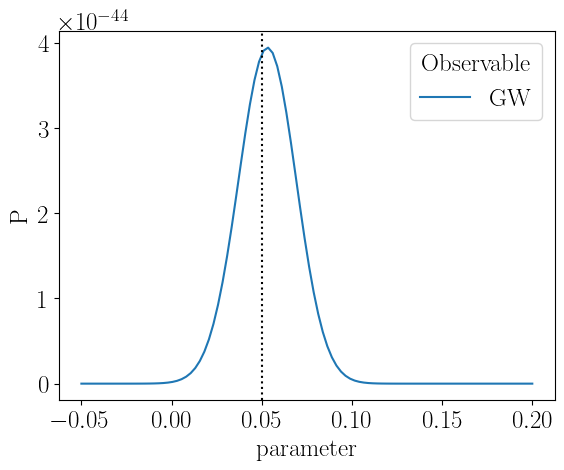

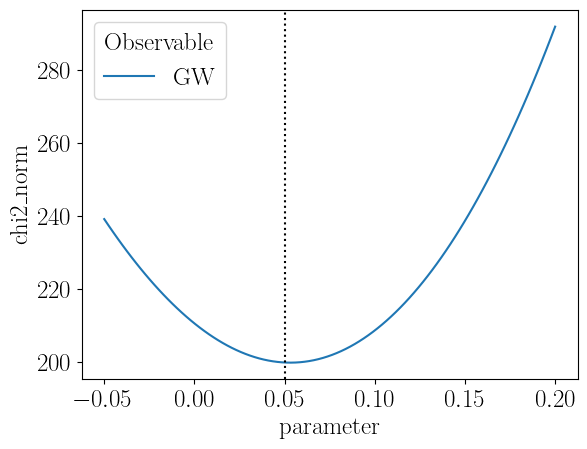

In [18]:
for obs in playground['Observable'].unique():
    par = obs_settings[obs]['run_settings']['varpar']
    df = playground[playground['Observable']==obs]
    plt.figure()
    sb.lineplot(df,x=playground.columns[0],y='P',hue='Observable')
    plt.axvline(x=fiducial[par],ls=':',color='black');
    
    plt.figure()
    sb.lineplot(df,x=playground.columns[0],y='chi2_norm',hue='Observable')
    plt.axvline(x=fiducial[par],ls=':',color='black');